# 목차
1. 분석의 방향
2. 데이터 Overview
3. 데이터 병합
4. 중복 제거
5. 결측치 제거
6. 이상치 제거
7. 상관관계 및 그래프
    
-------------------
# 1. 분석의 방향
중고차를 사려는 사람이 가장 먼저 결정하는 건 보통 예산 범위다.  
그리고 예산이 정해지면 자연스럽게 브랜드를 선택하는데, 브랜드는 이미지, 성능, 옵션 기대치를 함께 끌고 들어오기 때문에 처음 필터링에 큰 영향을 준다.

이번 분석은 중고차 판매자(공급자)의 입장에서 사람들이 어떤 가격대에 가장 많이 몰려 있는지, 그리고 그 가격대에서 어떤 브랜드가 상대적으로 우위를 보이는지를 확인하려고 한다.  
이를 통해 가격대별 인기 브랜드를 이해하고, 재고를 어떤 조합으로 맞추면 더 효율적인 공급 전략을 만들 수 있는지 탐색한다.

물론 실제 구매에서는 차량 상태나 개인 취향 같은 변수들이 크게 작용하기에 이러한 상관관계도 밝히고자 한다.
따라서 이번 분석은 아래와 같은 가정을 둔다.
고객의 예산이 우선적 제약이고, 브랜드는 그 안에서 선택이 바뀔 수 있다고 본다.

이러한 가정을 바탕으로 중고차 데이터분석을 통해 ['가격', '브랜드명']에 따른 고객의 수요를 파악하고자 한다.

### 접근방향
+ 가격대별 수요의 분포를 알고, 고객에게 소개해줄 라인업을 구성할 수 있지 않을까?
  + 가격대별 브랜드의 선호도는?
+ 차량의 상태를 어떻게 판단할 수 있을까? 

-------------------
# 2. 데이터 Overview
### 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA

cars_df = pd.read_csv('cars.csv')
brand_df = pd.read_csv('brand.csv')

cars_df.columns=['등록 차량','가격','운행 기록(마일)','등록년도','이전 차주(명)','연료','차체','엔진','기어','도어 수','시트 수','배출등급','정비 기록']
brand_df.columns=['브랜드','국가']

### Cars_df

In [2]:
cars_df.head()

,등록 차량,가격,운행 기록(마일),등록년도,이전 차주(명),연료,차체,엔진,기어,도어 수,시트 수,배출등급,정비 기록
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [3]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   등록 차량      3687 non-null   object 
 1   가격         3687 non-null   int64  
 2   운행 기록(마일)  3687 non-null   int64  
 3   등록년도       3687 non-null   int64  
 4   이전 차주(명)   2276 non-null   float64
 5   연료         3687 non-null   object 
 6   차체         3687 non-null   object 
 7   엔진         3642 non-null   object 
 8   기어         3687 non-null   object 
 9   도어 수       3662 non-null   float64
 10  시트 수       3652 non-null   float64
 11  배출등급       3600 non-null   object 
 12  정비 기록      540 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 374.6+ KB


In [4]:
cars_df.describe(include='all')

,등록 차량,가격,운행 기록(마일),등록년도,이전 차주(명),연료,차체,엔진,기어,도어 수,시트 수,배출등급,정비 기록
count,3687,3687.000000,3.687000e+03,3687.000000,2276.000000,3687,3687,3642,3687,3662.000000,3652.000000,3600,540
unique,455,NaN,NaN,NaN,NaN,6,10,34,2,NaN,NaN,6,1
top,VAUXHALL CORSA,NaN,NaN,NaN,NaN,Petrol,Hatchback,1.6L,Manual,NaN,NaN,Euro 5,Full
freq,223,NaN,NaN,NaN,NaN,2362,2280,736,2870,NaN,NaN,1257,540
mean,NaN,5787.301058,8.132854e+04,2011.846216,2.807557,NaN,NaN,NaN,NaN,4.321409,4.900329,NaN,NaN
std,NaN,4480.629885,3.941718e+04,5.082387,1.546028,NaN,NaN,NaN,NaN,0.986760,0.577046,NaN,NaN
min,NaN,400.000000,1.000000e+00,1953.000000,1.000000,NaN,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN
25%,NaN,2490.000000,5.698400e+04,2008.000000,2.000000,NaN,NaN,NaN,NaN,3.000000,5.000000,NaN,NaN
50%,NaN,4000.000000,8.000000e+04,2012.000000,3.000000,NaN,NaN,NaN,NaN,5.000000,5.000000,NaN,NaN
75%,NaN,7995.000000,1.030000e+05,2015.500000,4.000000,NaN,NaN,NaN,NaN,5.000000,5.000000,NaN,NaN


In [5]:
cars_df.isna().mean()*100

등록 차량         0.000000
가격            0.000000
운행 기록(마일)     0.000000
등록년도          0.000000
이전 차주(명)     38.269596
연료            0.000000
차체            0.000000
엔진            1.220504
기어            0.000000
도어 수          0.678058
시트 수          0.949281
배출등급          2.359642
정비 기록        85.353946
dtype: float64

### brand_df

In [6]:
brand_df.head()

,브랜드,국가
0,skoda,Czech Republic
1,vauxhall,United Kingdom
2,hyundai,South Korea
3,mini,United Kingdom
4,ford,United States


In [7]:
brand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   브랜드     48 non-null     object
 1   국가      48 non-null     object
dtypes: object(2)
memory usage: 900.0+ bytes


### 데이터 설명
+ 속성  
    'cars' 데이터는 아래와 같은 속성을 가지고 있다.  
    1. 등록 차량
    2. 가격
    3. 운행 기록(마일)
    4. 등록년도
    5. 이전 차주(명)
    6. 연료
    7. 차체
    8. 엔진
    9. 기어
    10. 도어 수
    11. 시트 수
    12. 배출등급
    13. 정비 기록


    'brand' 데이터는 아래와 같은 속성을 가지고 있다.  
    1. 브랜드
    2. 국가
+ 특이사항
    + 데이터 병합  
cars 데이터 내 '**등록차량**' 속성이 두 어절로 이루어져 있으며, 각각 '브랜드'와 '모델명'을 합쳐서 표기했다.  
brand 데이터와의 병합을 위해서 각 어절을 분리하고 데이터 형식을 맞춰주도록 한다.
    + 결측치
      + 이전 차주(명) : 38%
      + 엔진 : 1%
      + 도어 수 : 1%
      + 시트 수 : 1%
      + 배출등급 : 2%
      + 정비 기록 : 85%  
        '**이전 차주(명)**'과 '**정비 기록**'의 경우 데이터 비율의 상당량을 차지하므로, 단순히 누락된 행을 제거하여 분석을 진행할 수 없다.  
        두 속성의 경우 개인 차량 관리에서 빼놓지 않고 기록하는 데이터이기에 의도적으로 기재하지 않을 항목이 아니며, 이를 데이터 누락으로 처리하여 확인할 수 없는 값임을 명확히 한다.  
        또한 이 두 속성은 차량 가격과 직결되는 정보이기 때문에, 정보가 누락된 차량에 대하여 감가가 있는지를 찾아본다.</br>
        </br>'**엔진**','**도어 수**','**시트 수**','**배출등급**'은 차량 브랜드, 모델명, 등록년도가 같다면 같은 값을 적용할 수 있도록 한다.  
        물론 등록년도와 연식은 다른 개념이기에 실제로는 다를 수 있으나, 등록년도와 연식은 비슷할 것이라는 가정 하에 결측치를 제거한다.
    + 목표 데이터 형식
      + 등록차량 : string
      + 연료 : string
      + 차체 : string
      + 엔진 : float
      + 기어 : string
      + 배출등급 : int
      + 정비 기록 : bool
      + 국가 : string
    + 이상치 확인 필요
      + 가격 : 400 
      + 운행기록(마일) : 1
      + 이전 차주(명) : 9

--------------------
# 3. 중복 제거

In [8]:
cars_df[cars_df.duplicated()][['등록 차량','가격','운행 기록(마일)','등록년도','이전 차주(명)','정비 기록']].sort_index()

,등록 차량,가격,운행 기록(마일),등록년도,이전 차주(명),정비 기록
12,SKODA FABIA,6900,70189,2016,3.0,NaN
20,CITROEN C4,1949,114000,2013,NaN,NaN
25,VAUXHALL INSIGNIA,2950,79000,2011,4.0,NaN
39,MERCEDES-BENZ A CLASS,15900,62402,2019,1.0,NaN
52,VAUXHALL CORSA,10698,22782,2020,NaN,NaN
...,...,...,...,...,...,...
3662,MINI HATCH,11999,33156,2018,1.0,Full
3663,VAUXHALL ASTRA,4999,60139,2015,2.0,NaN
3674,MITSUBISHI OUTLANDER,1489,145000,2007,NaN,NaN
3675,VAUXHALL ASTRA,4999,60139,2015,2.0,NaN


In [9]:
cars_df = cars_df.drop_duplicates()

In [10]:
cars_df

,등록 차량,가격,운행 기록(마일),등록년도,이전 차주(명),연료,차체,엔진,기어,도어 수,시트 수,배출등급,정비 기록
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,RENAULT MEGANE,1395,76202,2006,4.0,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,NaN
3683,AUDI A4,6990,119000,2012,NaN,Petrol,Saloon,2.0L,Manual,4.0,5.0,Euro 5,NaN
3684,BMW 3 SERIES,3995,139000,2013,NaN,Diesel,Saloon,2.0L,Manual,4.0,5.0,Euro 5,NaN
3685,HONDA ACCORD,1390,179190,2007,NaN,Diesel,Estate,2.2L,Manual,5.0,5.0,Euro 4,Full


### 요약
같은 값이 둘 이상이 반복되는 828개의 행을 발견하였다.  
각각 다른 차량의 기록이라고 생각할 수 있겠으나, **모델명/가격/운행 기록(마일)/등록년도/정비기록**처럼 차량마다 다를 수 있는 항목에서 동일한 값을 가졌다는 것은 확률상 불가능하다.

따라서, 동일한 차량의 데이터라고 판단하였으며 중복 제거를 통해 **828 행을 제거**하였다.

--------------
# 4. 병합 과정

In [11]:
cars_df['등록 차량'].unique()

array(['SKODA FABIA', 'VAUXHALL CORSA', 'HYUNDAI I30', 'MINI HATCH',
       'HYUNDAI COUPE', 'FORD FOCUS', 'VOLVO 740', 'PEUGEOT 207',
       'FORD FIESTA', 'VAUXHALL INSIGNIA', 'BMW 3 SERIES', 'CITROEN C1',
       'CITROEN C4', 'VAUXHALL ASTRA', 'FORD MONDEO',
       'MERCEDES-BENZ A180', 'PEUGEOT 407', 'FORD KA',
       'MERCEDES-BENZ A CLASS', 'MAZDA MAZDA2', 'SAAB 9-3',
       'VOLKSWAGEN POLO', 'BMW 1 SERIES', 'HONDA ACCORD',
       'VOLKSWAGEN BEETLE', 'MG MG6', 'FORD C-MAX', 'HONDA CIVIC',
       'TOYOTA AURIS', 'VOLVO S40', 'SEAT IBIZA', 'PEUGEOT 308',
       'VAUXHALL MERIVA', 'MERCEDES-BENZ B CLASS', 'MAZDA MAZDA3',
       'NISSAN 350 Z', 'ALFA ROMEO MITO', 'RENAULT FLUENCE',
       'VOLKSWAGEN PASSAT', 'KIA SPORTAGE', 'CITROEN XM',
       'VAUXHALL ANTARA', 'NISSAN NOTE', 'BMW 5 SERIES', 'HONDA CR-V',
       'PROTON SAVVY', 'NISSAN MICRA', 'FIAT PANDA', 'RENAULT MEGANE',
       'RENAULT CLIO', 'HYUNDAI I20', 'CITROEN C3', 'AUDI A6 SALOON',
       'TOYOTA YARIS', 'FIAT 500', 

In [12]:
brand_df['브랜드'].unique()

array(['skoda', 'vauxhall', 'hyundai', 'mini', 'ford', 'volvo', 'peugeot',
       'bmw', 'citroen', 'mercedes-benz', 'mazda', 'saab', 'volkswagen',
       'honda', 'mg', 'toyota', 'seat', 'nissan', 'alfa', 'renault',
       'kia', 'proton', 'fiat', 'audi', 'mitsubishi', 'lexus', 'land',
       'chevrolet', 'suzuki', 'dacia', 'daihatsu', 'jeep', 'jaguar',
       'chrysler', 'rover', 'ds', 'daewoo', 'dodge', 'porsche', 'subaru',
       'infiniti', 'abarth', 'smart', 'marcos', 'maserati', 'ssangyong',
       'lagonda', 'isuzu'], dtype=object)

In [13]:
brand_df[brand_df['브랜드'].isin(cars_df['등록 차량'].unique())]
# 아무것도 발견되지 않음

,브랜드,국가


In [14]:
# 형식 변환
cars_df['등록 차량'] = cars_df['등록 차량'].astype('string')
brand_df['브랜드'] = brand_df['브랜드'].astype('string')
# 소문자 변경
cars_df['등록 차량'] = cars_df['등록 차량'].str.lower()
# 앞 어절을 추출하여 브랜드 피쳐 생성
cars_df['브랜드'] = cars_df['등록 차량'].str.split().str[0]
# 뒷 어절을 추출하여 모델명 피쳐 생성
cars_df['모델명'] = cars_df['등록 차량'].str.split().str[1]
# 브랜드, 모델명의 피쳐와 중복되므로 등록 차량 피쳐 drop
cars_df = cars_df.drop(['등록 차량'],axis=1)
# 브랜드를 키로 설정하여 cars_df 기준 brand_df를 병합
cars_df = cars_df.merge(brand_df, how='left', on='브랜드')
# cars_df에서 국가 피쳐에 대한 결측치가 있는지 확인
cars_df['국가'].isna().sum()

np.int64(0)

### 요약
기존의 데이터형식에서는 병합에 필요한 동일한 값이 발견되지 않았다.  
cars_df의 경우 '**등록차량**'이 '**브랜드**'+'**모델명**'의 형식이기에 이를 분리하고, 대문자로 이루어진 이름을 소문자로 바꾸어 brand의 형식과 일치시켜주었다.  

이 과정에서,
1. **'브랜드' 피쳐와 '모델명' 피쳐를 생성**하였으며,
2. **'등록 차량'의 피쳐가 중복됨으로 삭제**하였다.
3. 병합의 결과 모든 cars_df의 행이 brand_df와 결합하여 새로운 **'국가' 피쳐**가 생겼다.

--------------------
# 5. 결측치 제거

In [15]:
cars_df.isna().mean()*100

가격            0.000000
운행 기록(마일)     0.000000
등록년도          0.000000
이전 차주(명)     34.382651
연료            0.000000
차체            0.000000
엔진            0.594614
기어            0.000000
도어 수          0.874432
시트 수          1.224204
배출등급          2.063659
정비 기록        84.400140
브랜드           0.000000
모델명           0.000000
국가            0.000000
dtype: float64

### 이전 차주(명)

In [16]:
# 이전 차주에 대해 알 수 없다는 값으로 -99를 입력
cars_df['이전 차주(명)'] = cars_df['이전 차주(명)'].fillna(-99)

### 엔진, 도어 수, 시트 수, 배출등급

In [17]:
# 엔진의 경우 : (같은 브랜드, 모델, 등록년도라면 & cars_df['엔진']이 비지 않았다면) 그대로 값을 가져오기
nan_list=['엔진','도어 수','시트 수','배출등급']
for i in nan_list:
    # 대표값 추출
    unique_list=cars_df.groupby(['브랜드','모델명','등록년도'])[i].first()
    cars_df[i] = cars_df[i].fillna(cars_df[['브랜드','모델명','등록년도']].apply(lambda x: unique_list.get((x['브랜드'], x['모델명'], x['등록년도'])),axis=1))
 
# engine_unique = cars_df.groupby(['브랜드','모델명','등록년도'])['엔진'].first()
# cars_df['엔진'] = cars_df['엔진'].fillna(cars_df[['브랜드','모델명','등록년도']].apply(lambda x: engine_unique.get((x['브랜드'], x['모델명'], x['등록년도'])),axis=1))

In [26]:
cars_df.isna().mean()*100

가격           0.0
운행 기록(마일)    0.0
등록년도         0.0
이전 차주(명)     0.0
연료           0.0
차체           0.0
엔진           0.0
기어           0.0
도어 수         0.0
시트 수         0.0
배출등급         0.0
정비 기록        0.0
브랜드          0.0
모델명          0.0
국가           0.0
dtype: float64

In [19]:
# 엔진, 도어 수, 시트 수의 나머지 결측치를 -99로 채우기
cars_df[['엔진','도어 수','시트 수']] = cars_df[['엔진','도어 수','시트 수']].fillna(-99)

### 배출등급

In [20]:
cars_df['배출등급'].value_counts()

배출등급
Euro 5    1107
Euro 4     873
Euro 6     686
Euro 3     131
Euro 2      18
Euro 1       4
Name: count, dtype: int64

In [21]:
cars_df['배출등급'] = pd.to_numeric(cars_df['배출등급'].astype('string').str.split().str[-1])
cars_df['배출등급'] = cars_df['배출등급'].fillna(-99)

### 정비 기록

In [22]:
cars_df['정비 기록'].value_counts()

정비 기록
Full    446
Name: count, dtype: int64

In [25]:
cars_df['정비 기록'] = cars_df['정비 기록'].fillna(-1)
cars_df['정비 기록'] = cars_df['정비 기록'].replace({'Full':1}).astype('int')

### 요약
이전 차주(명)의 경우 

In [ ]:
for i in cars_list:
    if cars_df[i].isna():
        cars_df[i] = cars_df[i]
    [cars_df[i].notna()]

In [320]:
cars_df['정비 기록'].value_counts()
# 서비스 기록은 있거나, 없거나 이므로 원핫 인코딩

Service history
Full    440
Name: count, dtype: int64

In [321]:
cars_df=pd.get_dummies(cars_df, columns=['정비 기록'])

In [322]:
cars_df.isna().mean()*100

title                   0.0
Price                   0.0
Mileage(miles)          0.0
Registration_Year       0.0
Previous Owners         0.0
Fuel type               0.0
Body type               0.0
Engine                  0.0
Gearbox                 0.0
Doors                   0.0
Seats                   0.0
Emission Class          0.0
Service history_Full    0.0
dtype: float64

In [24]:
cars_df

,가격,운행 기록(마일),등록년도,차주 기록(명),연료,차체,엔진,기어,도어 수,시트 수,배출등급,정비 기록,브랜드,모델명,국가
0,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,skoda,fabia,Czech Republic
1,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,vauxhall,corsa,United Kingdom
2,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,hyundai,i30,South Korea
3,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,mini,hatch,United Kingdom
4,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,vauxhall,corsa,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2854,1395,76202,2006,4.0,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,NaN,renault,megane,France
2855,6990,119000,2012,NaN,Petrol,Saloon,2.0L,Manual,4.0,5.0,Euro 5,NaN,audi,a4,Germany
2856,3995,139000,2013,NaN,Diesel,Saloon,2.0L,Manual,4.0,5.0,Euro 5,NaN,bmw,3,Germany
2857,1390,179190,2007,NaN,Diesel,Estate,2.2L,Manual,5.0,5.0,Euro 4,Full,honda,accord,Japan


---------------------
# Type 변경
### 연료

In [328]:
cars_df.dtypes

title                   string[python]
Price                            int64
Mileage(miles)                   int64
Registration_Year                int64
Previous Owners                float64
Fuel type                       object
Body type                       object
Engine                          object
Gearbox                         object
Doors                          float64
Seats                          float64
Emission Class                  object
Service history_Full              bool
brand                           object
country                         object
dtype: object

In [329]:
cars_df['연료'].value_counts(normalize=True)*100

Fuel type
Petrol                   63.730755
Diesel                   35.553169
Petrol Hybrid             0.501253
Petrol Plug-in Hybrid     0.179019
Diesel Hybrid             0.035804
Name: proportion, dtype: float64

2%가 안 되는 값 제거 +> 인코딩
결과적으로 Petrol(휘발유), Diesel(경유)가 나타남

In [330]:
cars_df = cars_df[cars_df['연료'].isin(['Petrol','Diesel'])]
cars_df = pd.get_dummies(cars_df,columns=['연료'],drop_first=True)

### 차체

In [331]:
cars_df['차체'].value_counts()

Body type
Hatchback      1665
SUV             379
Saloon          289
MPV             129
Estate          118
Coupe           101
Convertible      88
Pickup            3
Combi Van         1
Name: count, dtype: int64

In [332]:
cars_df['차체'] = cars_df['차체'].astype('string')

### 엔진

In [333]:
cars_df['엔진'].value_counts().sort_index()

Engine
0.8L      2
0.9L     14
1.0L    204
1.1L     20
1.2L    387
1.3L    123
1.4L    364
1.5L    174
1.6L    535
1.7L     34
1.8L    118
1.9L     31
2.0L    464
2.1L     52
2.2L     66
2.3L      3
2.4L     21
2.5L     29
2.6L      2
2.7L     10
2.8L      3
3.0L     77
3.1L      1
3.2L      7
3.3L      1
3.5L      9
3.7L      5
4.2L      4
4.3L      2
4.4L      5
4.8L      1
5.0L      3
5.5L      1
6.3L      1
Name: count, dtype: int64

In [334]:
cars_df['엔진'] = pd.to_numeric(cars_df['엔진'].astype('string').str.rstrip('L'))

### 기어

In [335]:
cars_df['기어'].value_counts()

Gearbox
Manual       2160
Automatic     613
Name: count, dtype: int64

In [336]:
cars_df = pd.get_dummies(cars_df, columns=['기어'], drop_first=True)

### brand

In [339]:
cars_df['brand'].value_counts()

brand
VAUXHALL         390
FORD             320
BMW              222
VOLKSWAGEN       191
PEUGEOT          164
MERCEDES-BENZ    137
NISSAN           129
RENAULT          119
AUDI             117
TOYOTA            95
HONDA             93
CITROEN           91
FIAT              83
MINI              79
HYUNDAI           76
KIA               57
MAZDA             51
SKODA             47
SEAT              46
LAND              35
VOLVO             33
SUZUKI            32
JAGUAR            29
MITSUBISHI        19
ALFA              18
DACIA             14
CHEVROLET         14
MG                 9
INFINITI           7
LEXUS              7
SAAB               6
JEEP               6
DS                 5
CHRYSLER           5
SUBARU             4
SMART              4
MASERATI           3
ROVER              3
ABARTH             3
PROTON             2
DAIHATSU           2
SSANGYONG          2
PORSCHE            2
DAEWOO             1
DODGE              1
Name: count, dtype: int64

In [340]:
cars_df['brand'] = cars_df['brand'].astype('string')

### country

In [341]:
cars_df['country'].value_counts()

country
Germany           673
United Kingdom    545
Japan             439
France            379
United States     346
South Korea       136
Italy             107
Czech Republic     47
Spain              46
Sweden             39
Romania            14
Malaysia            2
Name: count, dtype: int64

In [342]:
cars_df['country']= cars_df['country'].astype('string')

# 이상치 제거

### 브랜드

In [19]:
cars_df['브랜드'].value_counts()

브랜드
vauxhall         395
ford             322
bmw              230
volkswagen       203
peugeot          164
mercedes-benz    140
nissan           134
renault          120
audi             119
toyota           107
honda            100
citroen           94
fiat              84
mini              79
hyundai           78
kia               58
mazda             54
seat              47
skoda             47
land              35
volvo             34
suzuki            34
jaguar            30
mitsubishi        21
alfa              18
dacia             14
chevrolet         14
mg                10
lexus              9
saab               7
infiniti           7
jeep               6
ds                 6
chrysler           5
rover              5
subaru             4
smart              4
proton             3
abarth             3
porsche            3
maserati           3
daihatsu           2
ssangyong          2
dodge              1
daewoo             1
marcos             1
lagonda            1
isuzu    

### 모델명

In [23]:
cars_df.groupby('브랜드')['모델명'].value_counts()

브랜드     모델명  
abarth  500       1
        595       1
        fiat      1
alfa    romeo    18
audi    a3       47
                 ..
volvo   v70       2
        xc90      2
        740       1
        c70       1
        s80       1
Name: count, Length: 352, dtype: int64

### 가격

<Axes: ylabel='Price'>

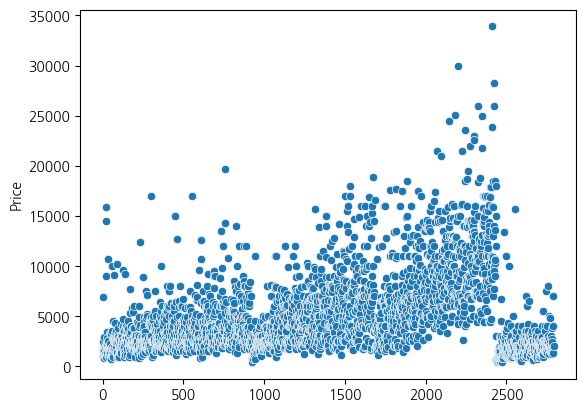

In [343]:
sns.scatterplot(cars_df['가격'])

In [344]:
cars_df['가격'].sort_values().head(20)

2439    400
2471    450
924     495
2440    499
2436    500
2593    500
2459    595
2443    640
2663    695
2457    699
2587    700
2464    700
2441    700
2444    700
52      700
931     750
2437    750
941     750
2580    790
943     795
Name: Price, dtype: int64

In [345]:
cars_df['가격'].sort_values().tail(20)

1676    18855
2260    19500
758     19698
2095    20999
2072    21495
2224    21495
2346    21798
2276    21998
2298    22600
2296    22999
2242    23600
2412    23910
2147    24444
2348    25000
2183    25100
2326    25995
2425    25995
2421    28240
2201    30000
2411    33900
Name: Price, dtype: int64

### 운행 기록(마일)

<Axes: ylabel='Mileage(miles)'>

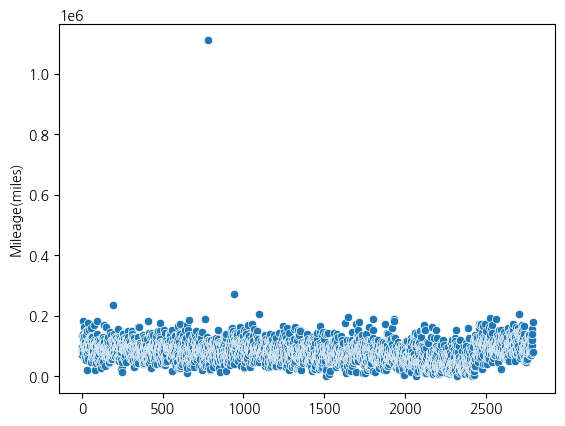

In [346]:
sns.scatterplot(cars_df['운행 기록(마일)'])

In [347]:
cars_df = cars_df.drop(cars_df[cars_df['운행 기록(마일)'] == cars_df['운행 기록(마일)'].max()].index)

<Axes: ylabel='Mileage(miles)'>

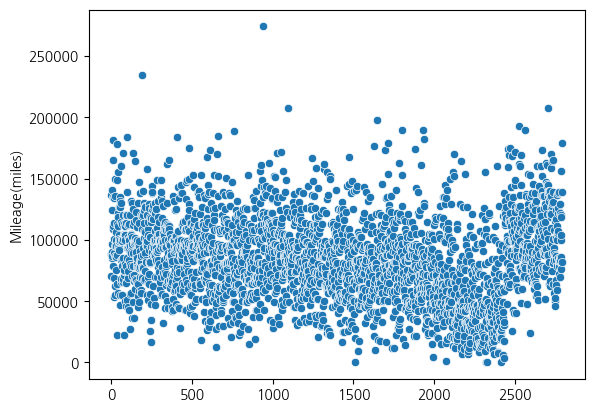

In [348]:
sns.scatterplot(cars_df['운행 기록(마일)'])

In [349]:
cars_df['운행 기록(마일)'].sort_values().head()

2416       1
2324       1
1511       6
2326     222
2072    1048
Name: Mileage(miles), dtype: int64

In [350]:
cars_df['운행 기록(마일)'].sort_values().tail(10)

764     189000
1803    189988
1931    190000
2564    190000
2528    192567
1648    197790
1096    207734
2704    208000
190     234680
943     274100
Name: Mileage(miles), dtype: int64

In [351]:
cars_df[cars_df['운행 기록(마일)'] < 5000]
# 100 미만의 숫자는 충분히 설명되지 않는다고 판단

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Body type,Engine,Doors,Seats,Emission Class,Service history_Full,brand,country,Fuel type_Petrol,Gearbox_Manual
1511,MG ZT,15500,6,2004,4.0,Saloon,1.8,4.0,5.0,3,False,MG,United Kingdom,True,True
1995,KIA CEED,13495,4750,2020,0.0,Estate,1.0,5.0,5.0,6,False,KIA,South Korea,True,True
2072,MG MG HS,21495,1048,2023,1.0,SUV,1.5,5.0,5.0,6,False,MG,United Kingdom,True,False
2324,MG MG ZS,18365,1,2023,0.0,SUV,1.5,5.0,5.0,6,False,MG,United Kingdom,True,True
2326,SEAT ATECA,25995,222,2023,0.0,SUV,1.5,5.0,5.0,6,False,SEAT,Spain,True,True
2416,MG MG ZS,18515,1,2023,0.0,SUV,1.5,5.0,5.0,6,False,MG,United Kingdom,True,True
2430,KIA XCEED HATCHBACK,18499,4000,2021,1.0,SUV,1.0,5.0,5.0,6,False,KIA,South Korea,True,True


In [352]:
cars_df=cars_df.drop(cars_df[cars_df['운행 기록(마일)'] < 100].index)

### 등록년도	

In [353]:
cars_df['등록년도'].value_counts().sort_index()

Registration_Year
1993      1
1997      3
1998      3
1999      4
2000      4
2001     15
2002     30
2003     50
2004     64
2005     79
2006    119
2007    173
2008    189
2009    211
2010    231
2011    237
2012    211
2013    230
2014    232
2015    171
2016    152
2017    104
2018     75
2019     81
2020     62
2021     28
2022      7
2023      3
Name: count, dtype: int64

# 원+핫 인코딩
### 브랜드, 나라, 바디타입

In [354]:
cars_df['brand'].value_counts()

brand
VAUXHALL         390
FORD             320
BMW              222
VOLKSWAGEN       190
PEUGEOT          164
MERCEDES-BENZ    137
NISSAN           129
RENAULT          119
AUDI             117
TOYOTA            95
HONDA             93
CITROEN           91
FIAT              83
MINI              79
HYUNDAI           76
KIA               57
MAZDA             51
SKODA             47
SEAT              46
LAND              35
VOLVO             33
SUZUKI            32
JAGUAR            29
MITSUBISHI        19
ALFA              18
DACIA             14
CHEVROLET         14
INFINITI           7
LEXUS              7
SAAB               6
MG                 6
JEEP               6
DS                 5
CHRYSLER           5
SUBARU             4
SMART              4
MASERATI           3
ROVER              3
ABARTH             3
PROTON             2
DAIHATSU           2
SSANGYONG          2
PORSCHE            2
DAEWOO             1
DODGE              1
Name: count, dtype: Int64

In [355]:
# 10대 미만의 브랜드는 others 로 묶기
brand_index = cars_df['brand'].value_counts().reset_index()
cars_df.loc[cars_df['brand'].isin(brand_index[brand_index['count'] < 10]['brand']),'brand'] = 'others'

In [356]:
cars_df['country'].value_counts()

country
Germany           672
United Kingdom    542
Japan             439
France            379
United States     346
South Korea       136
Italy             107
Czech Republic     47
Spain              46
Sweden             39
Romania            14
Malaysia            2
Name: count, dtype: Int64

In [357]:
cars_df['차체'].value_counts()

Body type
Hatchback      1664
SUV             377
Saloon          288
MPV             129
Estate          118
Coupe           101
Convertible      88
Pickup            3
Combi Van         1
Name: count, dtype: Int64

In [358]:
cars_df = cars_df.set_index('등록 차량')
one_hot_df = pd.get_dummies(cars_df, columns=['brand','country','차체'],drop_first=True)

# 상관관계 및 그래프 분포

<Axes: >

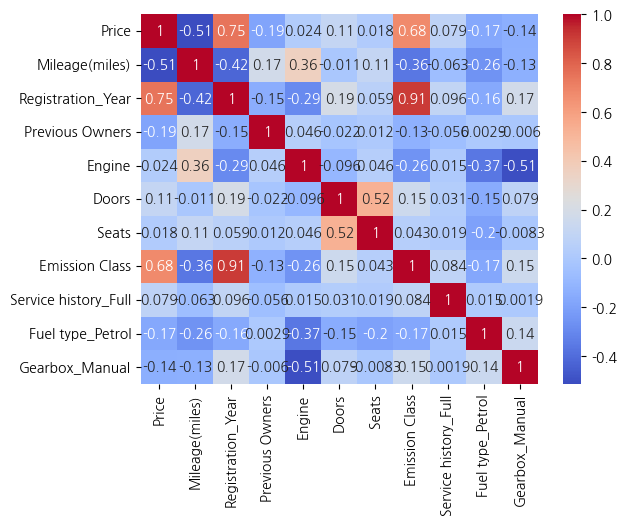

In [359]:
sns.heatmap(cars_df.corr(numeric_only=True), annot=True, cmap='coolwarm')

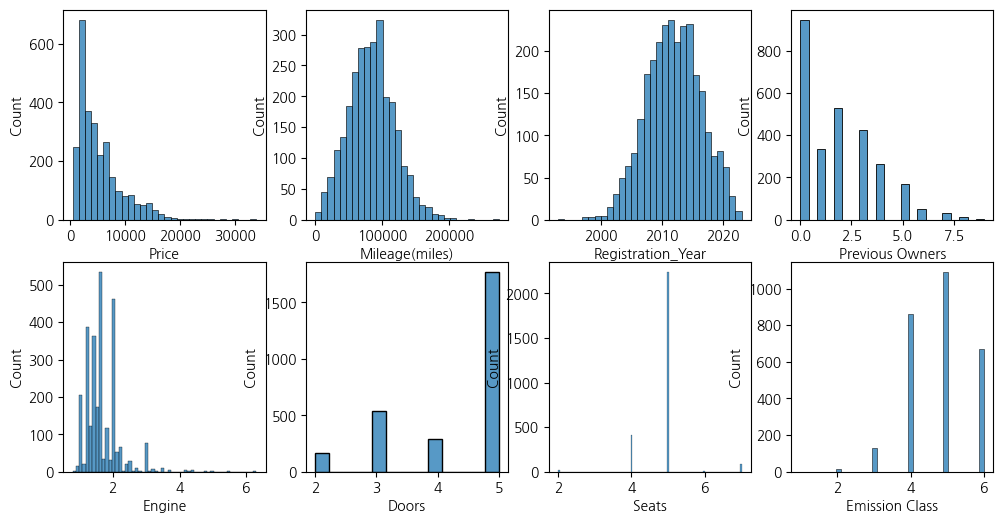

In [360]:
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot(2,4,1)
ax2=fig.add_subplot(2,4,2)
ax3=fig.add_subplot(2,4,3)
ax4=fig.add_subplot(2,4,4)
ax5=fig.add_subplot(2,4,5)
ax6=fig.add_subplot(2,4,6)
ax7=fig.add_subplot(2,4,7)
ax8=fig.add_subplot(2,4,8)
sns.histplot(cars_df, x='가격', ax=ax1, bins= 30)
sns.histplot(cars_df, x='운행 기록(마일)', ax=ax2, bins= 30)
sns.histplot(cars_df, x='등록년도', ax=ax3, bins= 30)
sns.histplot(cars_df, x='이전 차주(명)', ax=ax4)
sns.histplot(cars_df, x='엔진', ax=ax5)
sns.histplot(cars_df, x='도어 수', ax=ax6)
sns.histplot(cars_df, x='시트 수', ax=ax7)
sns.histplot(cars_df, x='배출등급',ax=ax8)
plt.show()

# 스케일링
주요 변수라고 생각하는 마일리지와 등록년도가 정규분포와 비슷한 형태를 띠기 때문에 StandardScaler을 사용

In [361]:
one_hot_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2769 entries, SKODA FABIA to VAUXHALL CORSA
Data columns (total 57 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   2769 non-null   int64  
 1   Mileage(miles)          2769 non-null   int64  
 2   Registration_Year       2769 non-null   int64  
 3   Previous Owners         2769 non-null   float64
 4   Engine                  2769 non-null   Float64
 5   Doors                   2769 non-null   float64
 6   Seats                   2769 non-null   float64
 7   Emission Class          2769 non-null   int64  
 8   Service history_Full    2769 non-null   bool   
 9   Fuel type_Petrol        2769 non-null   bool   
 10  Gearbox_Manual          2769 non-null   bool   
 11  brand_AUDI              2769 non-null   boolean
 12  brand_BMW               2769 non-null   boolean
 13  brand_CHEVROLET         2769 non-null   boolean
 14  brand_CITROEN           2

In [362]:
ss = StandardScaler()

In [363]:
ss.fit(one_hot_df)

,copy,True
,with_mean,True
,with_std,True


In [364]:
pd.DataFrame(ss.transform(one_hot_df),index=one_hot_df.index,columns=one_hot_df.columns)

,Price,Mileage(miles),Registration_Year,Previous Owners,Engine,Doors,Seats,Emission Class,Service history_Full,Fuel type_Petrol,...,country_United Kingdom,country_United States,Body type_Convertible,Body type_Coupe,Body type_Estate,Body type_Hatchback,Body type_MPV,Body type_Pickup,Body type_SUV,Body type_Saloon
title,,,,,,,,,,,,,,,,,,,,,
SKODA FABIA,0.401762,-0.398229,1.030140,0.596864,-0.474799,0.685790,0.188254,1.352921,-0.433477,-1.337355,...,-0.493332,-0.377886,-0.181173,-0.194566,-0.210977,0.814900,-0.221051,-0.032933,-0.397,-0.340708
VAUXHALL CORSA,-0.930543,0.137755,-0.763013,1.138206,-0.862394,-1.350620,0.188254,-0.935557,2.306928,0.747744,...,2.027031,-0.377886,-0.181173,-0.194566,-0.210977,0.814900,-0.221051,-0.032933,-0.397,-0.340708
HYUNDAI I30,-1.065129,1.548370,-0.090580,-1.027161,-0.474799,0.685790,0.188254,0.208682,-0.433477,0.747744,...,-0.493332,-0.377886,-0.181173,-0.194566,-0.210977,0.814900,-0.221051,-0.032933,-0.397,-0.340708
MINI HATCH,-0.708698,0.375096,-0.314725,1.679547,-0.474799,-1.350620,-1.515259,-0.935557,2.306928,0.747744,...,2.027031,-0.377886,-0.181173,-0.194566,-0.210977,0.814900,-0.221051,-0.032933,-0.397,-0.340708
VAUXHALL CORSA,-1.052558,0.033303,0.357708,-1.027161,-0.668596,0.685790,0.188254,0.208682,-0.433477,-1.337355,...,2.027031,-0.377886,-0.181173,-0.194566,-0.210977,0.814900,-0.221051,-0.032933,-0.397,-0.340708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RENAULT MEGANE,-0.955193,-0.223035,-1.211301,1.138206,-0.087205,0.685790,0.188254,-0.935557,-0.433477,0.747744,...,-0.493332,-0.377886,-0.181173,-0.194566,-0.210977,0.814900,-0.221051,-0.032933,-0.397,-0.340708
AUDI A4,0.423946,1.023923,0.133564,-1.027161,0.687983,-0.332415,0.188254,0.208682,-0.433477,0.747744,...,-0.493332,-0.377886,-0.181173,-0.194566,-0.210977,-1.227144,-0.221051,-0.032933,-0.397,2.935061
BMW 3 SERIES,-0.314306,1.606641,0.357708,-1.027161,0.687983,-0.332415,0.188254,0.208682,-0.433477,-1.337355,...,-0.493332,-0.377886,-0.181173,-0.194566,-0.210977,-1.227144,-0.221051,-0.032933,-0.397,2.935061


# 주성분 분석

In [365]:
pca=PCA(2)
pca.fit(one_hot_df)

,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [366]:
pd.DataFrame(pca.transform(one_hot_df))

,0,1
0,-13742.251817,788.045329
1,4950.772391,-3477.835827
2,53308.025480,-1051.643987
3,13026.186785,-2079.622508
4,1402.906611,-4191.904586
...,...,...
2764,-7402.750820,-4337.575913
2765,34971.224902,3873.334252
2766,55117.327115,2111.352704
2767,95391.441315,1977.661800


In [367]:
(pca.explained_variance_ratio_).sum()

np.float64(0.9999999860406634)